# Vector Semantics and Embeddings
Tutorial of Computational Linguistics, National Chengchi University

*Chang-Yu Tsai, 2025.03.21*

- In this week, we will try:
  - to obtain `word2vec` embeddings
  - to calculate the cosine similarity
  - to use `word2vec` embeddings on the classification task


- installing required packages

```
!apt-get install -y libopenblas-dev

!pip uninstall -y numpy scipy
!pip install numpy==1.23.5 scipy

!pip install --no-cache-dir --force-reinstall gensim==4.3.3
```

In [1]:
!apt-get install -y libopenblas-dev

!pip uninstall -y numpy scipy
!pip install numpy==1.23.5 scipy

!pip install --no-cache-dir --force-reinstall gensim==4.3.3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenblas-dev is already the newest version (0.3.20+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 wh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 236.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 255.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 221.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 147.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfu

- importing required packages

```
import gensim
from gensim.models import KeyedVectors

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import re

import jieba
```


In [1]:
import gensim
from gensim.models import KeyedVectors

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import re

import jieba

- mounting Google Drive
We sometimes need to upload some files to our Google Drive so that we can easily access them.



```
from google.colab import drive
drive.mount('/content/drive')
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- unzipping the file based on the path

You need to specify your own path since you might not have the same path as mine.

```
!gunzip /content/drive/MyDrive/NCCU/TA/1132_computational_linguistics/tmunlp_1.6B_WB_50dim_2020v1.bin.gz
```

In [3]:
!gunzip /content/drive/MyDrive/NCCU/TA/1132_computational_linguistics/tmunlp_1.6B_WB_50dim_2020v1.bin.gz



gzip: /content/drive/MyDrive/NCCU/TA/1132_computational_linguistics/tmunlp_1.6B_WB_50dim_2020v1.bin.gz: No such file or directory


## Obataining `word2vec` embeddings

The pre-trained `word2vec` we used this week is released by NLP lab of Taipei Medical University. You can find the pre-trained `word2vec` on [this website](https://nlp.tmu.edu.tw/word2vec/index.html). **Remember to upload the pre-trained word2vec embeddings to your Google Drive**

- loading the word2vec model

```
model_path = "/content/drive/MyDrive/NCCU/TA/1132_computational_linguistics/tmunlp_1.6B_WB_50dim_2020v1.bin"  # change it to your path
model = KeyedVectors.load_word2vec_format(model_path, binary=True)
```

In [4]:
model_path = "/content/drive/MyDrive/NCCU/TA/1132_computational_linguistics/tmunlp_1.6B_WB_50dim_2020v1.bin"  # change it to your path
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

- taking a look at the model

```
# inspecting the dimension number
embedding_dim = model.vector_size

# trying one example
bao_vec = model['包子']
print(bao_vec)
```

In [41]:
# inspecting the dimension number
embedding_dim = model.vector_size

# trying one example
bao_vec = model['郭明政']
print(bao_vec)

[ 0.03939709  0.87748957  0.5891481  -0.0494889  -0.8884852  -0.9439249
 -2.1584623   0.4707433   0.7568054  -1.7497302  -1.3811104   1.3812956
 -0.34357247 -0.9695176   2.4173968  -0.6606001   1.8496665   0.8596896
 -1.5014186   0.25639763  1.4031031  -2.601642    2.6664917   1.6678754
 -0.9717553  -1.9914287  -1.7524475  -1.2863373  -0.17542407  0.7642271
  0.24366891  0.961841    0.07089136  2.23068     0.19373402  2.597783
  0.5321358  -0.15419255  1.8069952   2.0417533   1.2764165   0.8042886
  2.4904401  -0.10286412  0.74022007 -1.2393279  -1.5197204  -0.50920516
 -0.68725973  0.16803437]


- what if the words do not exist in the model?

```
words = ['橘子','芭樂','蘋果','豆漿','油條','林有慧','夏天','眾量級']

# filtering out the words not existing in the model
existing_words = []
for word in words:
    if word in model:
        existing_words.append(word)  
    else:
      print(word, '不在模型中')
# obtaining the embeddings of each word
vectors_50d = []
for word in existing_words:
    vectors_50d.append(model[word])  
```

In [51]:
words = ['郭明政','政大','李蔡彥','蔡英文','油條','林有慧','夏天','眾量級']

# filtering out the words not existing in the model
existing_words = []
for word in words:
    if word in model:
        existing_words.append(word)
    else:
      print(word, '不在模型中')
# obtaining the embeddings of each word
vectors_50d = []
for word in existing_words:
    vectors_50d.append(model[word])

林有慧 不在模型中
眾量級 不在模型中


- converting the list into the array for following steps

```
vectors_50d = np.array(vectors_50d)
print(vectors_50d.shape)  # (sample numbers, 50)
sample_number=vectors_50d.shape[0]
print(sample_number)
```

In [52]:
vectors_50d = np.array(vectors_50d)
print(vectors_50d.shape)  # (sample numbers, 50)
sample_number=vectors_50d.shape[0]
print(sample_number)

(6, 50)
6


- projecting onto the 2D vector through `t-SNE`

```
tsne_2d = TSNE(n_components=2,perplexity=sample_number-1, random_state=42)
vectors_2d = tsne_2d.fit_transform(vectors_50d)
```

In [53]:
tsne_2d = TSNE(n_components=2,perplexity=sample_number-1, random_state=42)
vectors_2d = tsne_2d.fit_transform(vectors_50d)

## Cosine similarity


- calculating the cosine similarities among words

```
cos_sim_50d = cosine_similarity(vectors_50d)  # 50D (origine dimension)
cos_sim_2d = cosine_similarity(vectors_2d)  # 2D (projection dimension)
print(cos_sim_50d)
print(cos_sim_2d)
```

In [54]:
cos_sim_50d = cosine_similarity(vectors_50d)  # 50D (origine dimension)
cos_sim_2d = cosine_similarity(vectors_2d)  # 2D (projection dimension)
print(cos_sim_50d)
print(cos_sim_2d)

[[ 1.          0.5997649   0.3095945   0.25132394  0.07710287 -0.17976445]
 [ 0.5997649   1.0000001   0.21122064  0.36265674 -0.01629586 -0.1855727 ]
 [ 0.3095945   0.21122064  1.0000001   0.18201046  0.02142148 -0.20240921]
 [ 0.25132394  0.36265674  0.18201046  1.          0.22626206 -0.09429424]
 [ 0.07710287 -0.01629586  0.02142148  0.22626206  1.          0.1245083 ]
 [-0.17976445 -0.1855727  -0.20240921 -0.09429424  0.1245083   1.        ]]
[[ 1.          0.25093922 -0.8509212  -0.9656223  -0.8153933   0.22225562]
 [ 0.25093922  1.         -0.722015    0.00931915  0.35576963 -0.88801897]
 [-0.8509212  -0.722015    1.          0.6851188   0.38973936  0.32303298]
 [-0.9656223   0.00931915  0.6851188   1.          0.9378485  -0.46806258]
 [-0.8153933   0.35576963  0.38973936  0.9378485   0.9999998  -0.74565357]
 [ 0.22225562 -0.88801897  0.32303298 -0.46806258 -0.74565357  1.0000001 ]]


- displaying the result of cosine similarity amongs words

```
df_50d = pd.DataFrame(cos_sim_50d, index=existing_words, columns=existing_words)
df_2d = pd.DataFrame(cos_sim_2d, index=existing_words, columns=existing_words)

df_50d
# df_2d
```

In [55]:
df_50d = pd.DataFrame(cos_sim_50d, index=existing_words, columns=existing_words)
df_2d = pd.DataFrame(cos_sim_2d, index=existing_words, columns=existing_words)

# df_50d
df_2d

,郭明政,政大,李蔡彥,蔡英文,油條,夏天
郭明政,1.000000,0.250939,-0.850921,-0.965622,-0.815393,0.222256
政大,0.250939,1.000000,-0.722015,0.009319,0.355770,-0.888019
李蔡彥,-0.850921,-0.722015,1.000000,0.685119,0.389739,0.323033
蔡英文,-0.965622,0.009319,0.685119,1.000000,0.937849,-0.468063
油條,-0.815393,0.355770,0.389739,0.937849,1.000000,-0.745654
夏天,0.222256,-0.888019,0.323033,-0.468063,-0.745654,1.000000


- saving the dataframe of cosine similarity

```
df_50d.to_csv('df_50d.csv',encoding='utf-8',index=False)
```

In [47]:
df_50d.to_csv('df_50d.csv',encoding='utf-8',index=False)

## Visualisation

- downloading the font supporting Chinese characters

```
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
```

In [48]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download



--2025-03-21 05:18:30--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.153.113, 142.250.153.100, 142.250.153.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.153.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-03-21 05:18:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.127.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  27.4MB/s    in 0.7s    

2025-03-21 

- setting the font of the chart

```
matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')
```

In [56]:
matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

- plotting the vectors

```
# setting up the colour
gray_values = np.random.uniform(0.2, 0.8, size=len(existing_words))
colors = [(g, g, g) for g in gray_values]  

# plotting
for i, word in enumerate(existing_words):
    plt.arrow(0, 0,
              vectors_2d[i, 0], vectors_2d[i, 1],
              head_width=5, head_length=5,  # arrow size
              linewidth=1,                      # line size
              fc=colors[i], ec=colors[i], alpha=0.9)

    # label of each word
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=12, color=colors[i])

# chart label
plt.title("Word2Vec 2D Visualisation (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.savefig("word2vec_embeddings_visualisation.png", dpi=300, bbox_inches='tight')
```

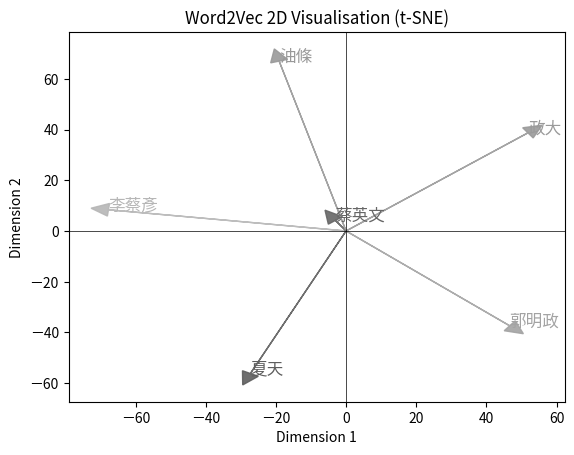

In [57]:
# setting up the colour
gray_values = np.random.uniform(0.2, 0.8, size=len(existing_words))
colors = [(g, g, g) for g in gray_values]

# plotting
for i, word in enumerate(existing_words):
    plt.arrow(0, 0,
              vectors_2d[i, 0], vectors_2d[i, 1],
              head_width=5, head_length=5,  # arrow size
              linewidth=1,                      # line size
              fc=colors[i], ec=colors[i], alpha=0.9)

    # label of each word
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=12, color=colors[i])

# chart label
plt.title("Word2Vec 2D Visualisation (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.savefig("word2vec_embeddings_visualisation.png", dpi=300, bbox_inches='tight')

## Using `word2vec` on classification tasks

### Preprocessing

- downloading the dataset from github
> Our data was collected from Cofacts. If you want to explore more on their dataset, please refer to [this website](https://huggingface.co/datasets/Cofacts/line-msg-fact-check-tw).

```
!wget https://raw.githubusercontent.com/EntropiaTsai/nccu_elt_course_material/refs/heads/main/balanced_misinformation.csv
```

In [19]:
!wget https://raw.githubusercontent.com/EntropiaTsai/nccu_elt_course_material/refs/heads/main/balanced_misinformation.csv



--2025-03-21 03:54:19--  https://raw.githubusercontent.com/EntropiaTsai/nccu_elt_course_material/refs/heads/main/balanced_misinformation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18379337 (18M) [text/plain]
Saving to: ‘balanced_misinformation.csv’

balanced_misinforma 100%[===================>]  17.53M  --.-KB/s    in 0.09s   

2025-03-21 03:54:20 (190 MB/s) - ‘balanced_misinformation.csv’ saved [18379337/18379337]



- reading the file

```
df = pd.read_csv('balanced_misinformation.csv',encoding='utf-8')
print('The dataframe contains', len(df), 'rows.')
df.head()
```

In [20]:
df = pd.read_csv('balanced_misinformation.csv',encoding='utf-8')
print('The dataframe contains', len(df), 'rows.')
df.head()

The dataframe contains 25170 rows.


,text,title,type
0,https://tw.news.yahoo.com/%E6%A0%B8%E5%BB%A2%E...,政治,OPINIONATED
1,"昨天6/15時鐘說,政府買進居\n家快篩劑一份一千元,需要的\n民眾可以洽購。\n今天6/1...",法律,RUMOR
2,桃園市議會 通過112年度預算 明年起即可全面適用\n☝️自111學年度下學期起，全面推動...,法律,NOT_RUMOR
3,救命藥出現了？ 美治療首例確診病患 1天後退燒 實驗藥奏效\n\n世界日報\n2020/02...,健康醫療,RUMOR
4,一月初我被幾個中國醫生朋友拉入中國人所成立的幫助武漢群組WeChat裡面，我在裡面什麼都沒幹...,政治,OPINIONATED


- segmentation with `jieba`

```
segmentation=[]
for text in df['text']:
  seg = jieba.cut(text)
  segmentation.append(list(seg))
df['segmentation']=segmentation
df.head()
```

In [21]:
segmentation=[]
for text in df['text']:
  seg = jieba.cut(text)
  segmentation.append(list(seg))
df['segmentation']=segmentation
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.023 seconds.
DEBUG:jieba:Loading model cost 1.023 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,text,title,type,segmentation
0,https://tw.news.yahoo.com/%E6%A0%B8%E5%BB%A2%E...,政治,OPINIONATED,"[https, :, /, /, tw, ., news, ., yahoo, ., com..."
1,"昨天6/15時鐘說,政府買進居\n家快篩劑一份一千元,需要的\n民眾可以洽購。\n今天6/1...",法律,RUMOR,"[昨天, 6, /, 15, 時鐘, 說, ,, 政府, 買, 進居, \n, 家快, 篩劑..."
2,桃園市議會 通過112年度預算 明年起即可全面適用\n☝️自111學年度下學期起，全面推動...,法律,NOT_RUMOR,"[桃園, 市議, 會, , 通過, 112, 年度, 預算, , , 明年, 起, 即..."
3,救命藥出現了？ 美治療首例確診病患 1天後退燒 實驗藥奏效\n\n世界日報\n2020/02...,健康醫療,RUMOR,"[救命, 藥出現, 了, ？, , 美, 治療, 首例, 確診, 病患, , 1, 天後..."
4,一月初我被幾個中國醫生朋友拉入中國人所成立的幫助武漢群組WeChat裡面，我在裡面什麼都沒幹...,政治,OPINIONATED,"[一, 月初, 我, 被, 幾個, 中國, 醫生, 朋友, 拉入, 中國人, 所, 成立, ..."


- obtaining word2vec embeddings

```
embeddings_list = []
for words in df['segmentation']: # for each row
  word_embeddings = []  # saving the embeddings of the current row
  for word in words:
    if word in model:
      """
      only obtaining the embeddings of words existing in the model
      """
      word_embeddings.append(model[word])  
  
  if len(word_embeddings) > 0:
    """
    The list `word_embeddings` contains embeddings.
    """
    avg_embedding = np.mean(word_embeddings, axis=0)
  else:
    """
    The list `word_embeddings` remains empty.
    """
    avg_embedding = np.zeros(model.vector_size)

  # saving the averaging embeddings of the current row
  embeddings_list.append(avg_embedding)
```

In [22]:
embeddings_list = []
for words in df['segmentation']: # for each row
  word_embeddings = []  # saving the embeddings of the current row
  for word in words:
    if word in model:
      """
      only obtaining the embeddings of words existing in the model
      """
      word_embeddings.append(model[word])

  if len(word_embeddings) > 0:
    """
    The list `word_embeddings` contains embeddings.
    """
    avg_embedding = np.mean(word_embeddings, axis=0)
  else:
    """
    The list `word_embeddings` remains empty.
    """
    avg_embedding = np.zeros(model.vector_size)

  # saving the averaging embeddings of the current row
  embeddings_list.append(avg_embedding)

- converting the embedding list in an n*50 dataframe (50 dimensions)

```
# creating the dataframe based on `embeddings_list`
df_embeddings = pd.DataFrame(embeddings_list, dtype=np.float32)

# concatenating the `df` and `df_embeddings`
new_df = pd.concat([df, df_embeddings], axis=1)

print("DataFrame shape:", new_df.shape)  # (row number, previous column number + 50)
new_df.head()
```

In [23]:
# creating the dataframe based on `embeddings_list`
df_embeddings = pd.DataFrame(embeddings_list, dtype=np.float32)

# concatenating the `df` and `df_embeddings`
new_df = pd.concat([df, df_embeddings], axis=1)

print("DataFrame shape:", new_df.shape)  # (row number, previous column number + 50)
new_df.head()

DataFrame shape: (25170, 54)


,text,title,type,segmentation,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,https://tw.news.yahoo.com/%E6%A0%B8%E5%BB%A2%E...,政治,OPINIONATED,"[https, :, /, /, tw, ., news, ., yahoo, ., com...",-2.153337,-1.066428,-2.873839,2.269944,1.290683,-2.338625,...,-2.132251,0.663343,0.455899,5.581812,2.557480,-2.046292,-0.527512,3.320735,1.472242,-0.208138
1,"昨天6/15時鐘說,政府買進居\n家快篩劑一份一千元,需要的\n民眾可以洽購。\n今天6/1...",法律,RUMOR,"[昨天, 6, /, 15, 時鐘, 說, ,, 政府, 買, 進居, \n, 家快, 篩劑...",0.436681,-0.252390,-2.009871,-1.410897,-0.105529,-1.208724,...,1.754447,0.248582,-0.073556,1.354481,3.115616,-1.417886,4.338680,3.762317,-1.446355,-0.973981
2,桃園市議會 通過112年度預算 明年起即可全面適用\n☝️自111學年度下學期起，全面推動...,法律,NOT_RUMOR,"[桃園, 市議, 會, , 通過, 112, 年度, 預算, , , 明年, 起, 即...",0.229099,0.405742,-1.811745,-1.409550,-3.665826,0.307954,...,-0.784112,1.648064,-0.007043,-1.882060,-0.272630,0.085687,1.540056,-1.602636,-0.133235,-1.946369
3,救命藥出現了？ 美治療首例確診病患 1天後退燒 實驗藥奏效\n\n世界日報\n2020/02...,健康醫療,RUMOR,"[救命, 藥出現, 了, ？, , 美, 治療, 首例, 確診, 病患, , 1, 天後...",-0.465627,-0.346966,-1.162416,0.858090,2.609961,-1.784747,...,-0.223379,-0.285486,-1.246073,0.364891,4.161027,0.246893,2.296163,2.703643,0.641019,0.756226
4,一月初我被幾個中國醫生朋友拉入中國人所成立的幫助武漢群組WeChat裡面，我在裡面什麼都沒幹...,政治,OPINIONATED,"[一, 月初, 我, 被, 幾個, 中國, 醫生, 朋友, 拉入, 中國人, 所, 成立, ...",-1.757582,2.424902,-0.385625,-1.553340,-1.857123,0.450401,...,1.646917,0.569002,1.722651,4.970322,3.366065,-0.838592,0.943703,-0.280648,-5.142182,0.405624


- encoding data
  - We need to encode contents that cannot be understood by the model. `LabelEncoder()` is one of the common approaches.

```
# converting labels
labels_label_encoder = LabelEncoder()
new_df["type_encoded"] = labels_label_encoder.fit_transform(new_df["type"])
new_df.head()
```

In [24]:
# converting labels
labels_label_encoder = LabelEncoder()
new_df["type_encoded"] = labels_label_encoder.fit_transform(new_df["type"])
new_df.head()

,text,title,type,segmentation,0,1,2,3,4,5,...,41,42,43,44,45,46,47,48,49,type_encoded
0,https://tw.news.yahoo.com/%E6%A0%B8%E5%BB%A2%E...,政治,OPINIONATED,"[https, :, /, /, tw, ., news, ., yahoo, ., com...",-2.153337,-1.066428,-2.873839,2.269944,1.290683,-2.338625,...,0.663343,0.455899,5.581812,2.557480,-2.046292,-0.527512,3.320735,1.472242,-0.208138,1
1,"昨天6/15時鐘說,政府買進居\n家快篩劑一份一千元,需要的\n民眾可以洽購。\n今天6/1...",法律,RUMOR,"[昨天, 6, /, 15, 時鐘, 說, ,, 政府, 買, 進居, \n, 家快, 篩劑...",0.436681,-0.252390,-2.009871,-1.410897,-0.105529,-1.208724,...,0.248582,-0.073556,1.354481,3.115616,-1.417886,4.338680,3.762317,-1.446355,-0.973981,2
2,桃園市議會 通過112年度預算 明年起即可全面適用\n☝️自111學年度下學期起，全面推動...,法律,NOT_RUMOR,"[桃園, 市議, 會, , 通過, 112, 年度, 預算, , , 明年, 起, 即...",0.229099,0.405742,-1.811745,-1.409550,-3.665826,0.307954,...,1.648064,-0.007043,-1.882060,-0.272630,0.085687,1.540056,-1.602636,-0.133235,-1.946369,0
3,救命藥出現了？ 美治療首例確診病患 1天後退燒 實驗藥奏效\n\n世界日報\n2020/02...,健康醫療,RUMOR,"[救命, 藥出現, 了, ？, , 美, 治療, 首例, 確診, 病患, , 1, 天後...",-0.465627,-0.346966,-1.162416,0.858090,2.609961,-1.784747,...,-0.285486,-1.246073,0.364891,4.161027,0.246893,2.296163,2.703643,0.641019,0.756226,2
4,一月初我被幾個中國醫生朋友拉入中國人所成立的幫助武漢群組WeChat裡面，我在裡面什麼都沒幹...,政治,OPINIONATED,"[一, 月初, 我, 被, 幾個, 中國, 醫生, 朋友, 拉入, 中國人, 所, 成立, ...",-1.757582,2.424902,-0.385625,-1.553340,-1.857123,0.450401,...,0.569002,1.722651,4.970322,3.366065,-0.838592,0.943703,-0.280648,-5.142182,0.405624,1


- seperating the features and labels

When there are too many columns to name them all, we can use `df.drop()` to remove the columns we do not need.
```
features=new_df.drop(['text','title','type','segmentation','type_encoded'],axis=1)
labels=new_df['type_encoded']
```

In [25]:
features=new_df.drop(['text','title','type','segmentation','type_encoded'],axis=1)
labels=new_df['type_encoded']

In [26]:
features

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-2.153337,-1.066428,-2.873839,2.269944,1.290683,-2.338625,-6.950126,3.447979,3.001115,1.646001,...,-2.132251,0.663343,0.455899,5.581812,2.557480,-2.046292,-0.527512,3.320735,1.472242,-0.208138
1,0.436681,-0.252390,-2.009871,-1.410897,-0.105529,-1.208724,-0.870688,-1.160816,-0.324238,-2.582218,...,1.754447,0.248582,-0.073556,1.354481,3.115616,-1.417886,4.338680,3.762317,-1.446355,-0.973981
2,0.229099,0.405742,-1.811745,-1.409550,-3.665826,0.307954,-1.023243,2.502554,2.290601,-1.062658,...,-0.784112,1.648064,-0.007043,-1.882060,-0.272630,0.085687,1.540056,-1.602636,-0.133235,-1.946369
3,-0.465627,-0.346966,-1.162416,0.858090,2.609961,-1.784747,-5.528017,2.949198,-0.305507,1.940512,...,-0.223379,-0.285486,-1.246073,0.364891,4.161027,0.246893,2.296163,2.703643,0.641019,0.756226
4,-1.757582,2.424902,-0.385625,-1.553340,-1.857123,0.450401,-1.598806,-3.689767,-0.378188,-4.008918,...,1.646917,0.569002,1.722651,4.970322,3.366065,-0.838592,0.943703,-0.280648,-5.142182,0.405624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25165,-1.545856,1.762995,1.112511,-0.950661,-0.108278,-0.129261,-1.379542,-4.431275,1.007776,-4.873837,...,0.792368,1.446453,-1.857351,3.946544,4.171894,1.071072,-0.452153,-0.990528,-4.838501,2.224387
25166,2.587719,2.571416,3.663583,1.694578,3.783068,-2.574160,-4.425523,1.134676,-0.011880,-1.701928,...,0.387128,-0.819585,-2.138292,-0.123916,5.446517,-0.725884,-1.015221,-1.237730,-0.216136,-0.338006
25167,-1.987404,3.462120,-1.555428,-0.323002,1.919277,-0.023719,-2.592828,-2.284432,0.103880,-1.802989,...,1.564257,0.463292,1.964749,4.964371,4.787544,0.286792,-0.655018,-0.168628,-2.791329,1.924288
25168,1.574780,-0.154160,0.787460,2.213170,1.816907,-3.671566,-3.163971,3.622896,-0.547254,-0.449981,...,1.744331,-0.527636,-3.281467,1.014904,7.186574,1.534491,4.792196,2.840575,-0.200769,-2.070395


- dividing them into the training set and the test set

```
feat_train, feat_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)
```

In [27]:
feat_train, feat_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)



- Converting features and labels into tensors


```
# converting data into Tensor
feat_train_tensor = torch.tensor(feat_train.values, dtype=torch.float32)
label_train_tensor = torch.tensor(label_train.values, dtype=torch.long)

feat_test_tensor = torch.tensor(feat_test.values, dtype=torch.float32)
label_test_tensor = torch.tensor(label_test.values, dtype=torch.long)
```

In [28]:
# converting data into Tensor
feat_train_tensor = torch.tensor(feat_train.values, dtype=torch.float32)
label_train_tensor = torch.tensor(label_train.values, dtype=torch.long)

feat_test_tensor = torch.tensor(feat_test.values, dtype=torch.float32)
label_test_tensor = torch.tensor(label_test.values, dtype=torch.long)

- Creating datasets for mini-batch training

```
# converting `TensorDataset`
dataset_train = TensorDataset(feat_train_tensor, label_train_tensor)
dataset_test = TensorDataset(feat_test_tensor, label_test_tensor)
# setting  batch size
batch_size = 32
# converting `TensorDataset` into `DataLoader` for mini-batch training
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
```

In [29]:
# converting `TensorDataset`
dataset_train = TensorDataset(feat_train_tensor, label_train_tensor)
dataset_test = TensorDataset(feat_test_tensor, label_test_tensor)
# setting  batch size
batch_size = 32
# converting `TensorDataset` into `DataLoader` for mini-batch training
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Model training

- Multinomial Logistic Regression: for multi-class task
  - $ \hat C = softmax(W \cdot F+b)$
    > $C = class$; $F = feature$; $w = weight$; $b = bias$


- defining the models

```
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(feature_dim,
                                num_classes) # We need to specify the class number based on our dataset.

    def forward(self, x):
      """
      No need to specify softmax() here, since the loss function we use already calculates it internally.
      """
      return self.linear(x)
```

In [30]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(feature_dim,
                                num_classes) # We need to specify the class number based on our dataset.

    def forward(self, x):
      """
      No need to specify softmax() here, since the loss function we use already calculates it internally.
      """
      return self.linear(x)

- initialising the model

```
torch.manual_seed(4) # the random seed of initialisation
multinomial_model = MultinomialLogisticRegression(feature_dim=feat_train_tensor.shape[1],
                                                  num_classes=len(torch.unique(label_train_tensor))) #initialising
multinomial_criterion = nn.CrossEntropyLoss() # Bross Entropy loss function

# setting up the optimiser
learning_rate = 0.01 # learning rate
l2_lambda = 0.001    # lambda of l2 regularisation

multinomial_optimizer = optim.SGD(multinomial_model.parameters(), lr=learning_rate, weight_decay=l2_lambda)    
```

In [31]:
torch.manual_seed(4) # the random seed of initialisation
multinomial_model = MultinomialLogisticRegression(feature_dim=feat_train_tensor.shape[1],
                                                  num_classes=len(torch.unique(label_train_tensor))) #initialising
multinomial_criterion = nn.CrossEntropyLoss() # Bross Entropy loss function

# setting up the optimiser
learning_rate = 0.01 # learning rate
l2_lambda = 0.001    # lambda of l2 regularisation

multinomial_optimizer = optim.SGD(multinomial_model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

- training the model

```
multinomial_model.train()
for batch_feat, batch_label in train_loader:

    # We first convert Tensors into particular formats.
    
    batch_feat = batch_feat.float()  # ensuring features to be 32-bit floats
    batch_label = batch_label.long() # ensuring labels to be be long integers

    multinomial_optimizer.zero_grad() # clearing previous gradients to prevent accumulation
    multinomial_predictions = multinomial_model(batch_feat) # performing forward pass
    multinomial_loss = multinomial_criterion(multinomial_predictions, batch_label) # calculating loss

    multinomial_loss.backward() # computing gradients for the current batch (Backward Pass)
    multinomial_optimizer.step() # updating model parameters using gradient descent
```

In [32]:
multinomial_model.train()
for batch_feat, batch_label in train_loader:

    # We first convert Tensors into particular formats.

    batch_feat = batch_feat.float()  # ensuring features to be 32-bit floats
    batch_label = batch_label.long() # ensuring labels to be be long integers

    multinomial_optimizer.zero_grad() # clearing previous gradients to prevent accumulation
    multinomial_predictions = multinomial_model(batch_feat) # performing forward pass
    multinomial_loss = multinomial_criterion(multinomial_predictions, batch_label) # calculating loss

    multinomial_loss.backward() # computing gradients for the current batch (Backward Pass)
    multinomial_optimizer.step() # updating model parameters using gradient descent

### Predicting and evaluating


```
# prediciting
multinomial_model.eval()
label_true = []
label_pred = []

with torch.no_grad():
    for batch_feat, batch_label in test_loader:
        batch_feat = batch_feat.float()
        batch_label = batch_label.long()
        test_predictions = multinomial_model(batch_feat)

        predicted_labels = torch.argmax(test_predictions, dim=1)

        label_true.extend(batch_label.cpu().numpy())
        label_pred.extend(predicted_labels.cpu().numpy())
# evaluating
accuracy = accuracy_score(label_true, label_pred)
precision = precision_score(label_true, label_pred, average='weighted')
recall = recall_score(label_true, label_pred, average='weighted')
f1 = f1_score(label_true, label_pred, average='weighted')

# printing out the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


```


In [33]:
# prediciting
multinomial_model.eval()
label_true = []
label_pred = []

with torch.no_grad():
    for batch_feat, batch_label in test_loader:
        batch_feat = batch_feat.float()
        batch_label = batch_label.long()
        test_predictions = multinomial_model(batch_feat)

        predicted_labels = torch.argmax(test_predictions, dim=1)

        label_true.extend(batch_label.cpu().numpy())
        label_pred.extend(predicted_labels.cpu().numpy())
# evaluating
accuracy = accuracy_score(label_true, label_pred)
precision = precision_score(label_true, label_pred, average='weighted')
recall = recall_score(label_true, label_pred, average='weighted')
f1 = f1_score(label_true, label_pred, average='weighted')

# printing out the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Test Accuracy: 0.4712
Precision: 0.5234, Recall: 0.4712, F1 Score: 0.4567


# Assignment


Please create a new `ipynb` to write down your assignment. Don't forget to include your name and related information at the top of your codes.

1. Pre-trained `word2vec` embeddings
  - Utilise other pre-trained `word2vec` models to obtain embeddings of words we worked on in class(15\%):
  
  `words = ['橘子','芭樂','蘋果','豆漿','油條','林有慧','夏天','眾量級']`

    *(Hint: You can find several pre-trained word2vec models on [this website](https://nlp.tmu.edu.tw/word2vec/index.html), including the 50 dim `word2vec` we used in class.)*

2. Cosine similarity and Visualisation
  - Calculate the cosine similarity and print out the dataframe. (10\%)
  - Compare the cosine similarities and the ones in class. Try to explain the differences between them. (20\%)
  
    *(Hint: We used the 50 dim `word2vec` model in class. As you try `word2vec` models with different dimension number, you might find the values incline or decline.)*

  - Plot a 2D vector chart based on the `word2vec` embeddings you obtain. (15\%)

4. Classification

  - Preprecess the texts in the `misinformation.csv`. Remove anything that you believe provise less informataion and explain your reason. (15\%)
  - Train the model with `word2vec` embeddings based on the model you select. Predict and evaluate the model. (15\%)
  
